In [ ]:
#5.11 high way
# last modified 2024/4/24 
# %matplotlib ipympl
%matplotlib inline
import h5py 
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import os
import datetime
import matplotlib
import logging
import csv
import time
def concat(flist , start = 0 , span = 20 ):
    datalist = []

    for fname in flist[ start : min( start + span , len(flist) ) ]:
        data = dp.read_das(fname)
        datalist.append(data)

    
    data = np.concatenate(datalist, axis = 1)
    utc_datetime = datetime.datetime.strptime(flist[start][-22 : -7],'%Y%m%d_%H%M%S') + datetime.timedelta(hours=+8)
    utc_day = utc_datetime.strftime("%m-%d %H:%M")
    print("cat", data.shape)
    return data , utc_datetime, utc_day 


def psd(h5file , startn, endn , span_each_pic , dt , window ):
    with h5py.File(h5file, 'w') as f:
    # 创建一个dataset
        concat_time = 0
        for n in range(startn, endn , span_each_pic):
            data , utc_datetime, utc_day = concat(flist , start= n ,span= span_each_pic)
            ch_list = [i for i in range(0,len(data))]

            fs = 1/dt
            data = dp.das_preprocess(data)
            nfft = window*fs
            start = time.time()
            for i in range(len(ch_list)):
                ch = ch_list[i]
                if not f.__contains__(str(ch_list[i])):   #判断这个组存不存在
                    g = f.create_group(str(ch_list[i]))
                else:
                    g = f[str(ch_list[i])]
                # g =  f.create_group(str(ch_list[i]))  
                [f1,Pxx1] = signal.welch(data[i],                   # 随机信号
                                nfft=nfft,               # 每个窗的长度
                                fs=fs,                   # 采样频率   
                                average='median' , 
                                # detrend='mean',          # 去掉均值
                                window=np.hanning(nfft), # 加汉尼窗
                                noverlap=int(nfft*3/4),  # 每个窗重叠75%的数据
                                )        # 求单边谱
                g.create_dataset(str(utc_day),  data=Pxx1 )
            concat_time +=  time.time() -start
            print(n , "拼接运行时间:%.2f min %d s"%( int(concat_time / 60) , concat_time%60) , datetime.datetime.now() , utc_day, "check in ")
        f.close()



flist = glob.glob('/mnt/f/Highway_2024_0510/Waihuan_HW_0628/data2/*.h5')
flist.sort()
print(len(flist))

path = '/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/'
if not os.path.exists(path):
    os.makedirs(path)

h5fname = path+ '/psd_7_3.hdf5'
psd(h5fname , 480, 643 , 4 , dt= 0.002 , window=6 ) 



In [ ]:
h5fname = path+ '/test03_05_10_1.hdf5'

with h5py.File(h5fname, 'w') as f:
    print(h5fname)


In [ ]:
import os
import scipy
from DasTools import DasPrep as dp
import h5py
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import os
import time

##########################################
def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = '', c = -1 , r = 1):
    fonts = 15
    if c > 0 :
        ax.set_yticks([])
    else:
        ax.set_yticks(ysticks[0],ysticks[1])
        ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xticks([])
    if r < 0 :
        ax.set_xticks([0],[xsticks[0]*8], rotation=90)
    elif r == 2 and c%2 == 1 and c//2 > 0 :
        ax.set_xticks([0],[c//2])
    # ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    # ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel_split(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  
                                                save_path ,split , t_range = [0,-1] , 
                                                lp = 1 , hp = 200 ,
                                                w = 20,
                                                start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC = np.abs(np.fft.ifft2(np.append(all_psd[::-1 , ] , all_psd ,axis= 1))[: , : len(all_psd[0])])
            time = ""
            print(all_AC.shape)

    all_AC = all_AC[:,:1001]
    all_psd=all_psd[:,:601]
    sum_psd = np.sum(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /70000).T
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, lp , hp )
    title = "w = " + str(w) + " " + str(lp) + "-" + str(hp) + " Hz"
    # filter_data = dp.lowpass(deco, 0.001, 60 )

    fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//10,11) ]
    time_stick = [np.linspace(0,len(all_AC[0]) , 4) ,np.around( np.linspace(0, len(all_AC[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    w_r = [ ]
    sp_ch_list= []
    start_ch = 0
    for i in split:
        w_r.append(  np.ceil((i - start_ch)/10))
        sp_ch_list.append([start_ch, i])
        start_ch = i
    
    print(w_r , sp_ch_list)
    fig, ax_list = plt.subplots(3, len(split), gridspec_kw={"width_ratios": w_r, "height_ratios": [1, 1, 1]} , figsize=(20, 12 ))

    filter_data_s = filter_data/np.max(filter_data) * 20

    ax_r1 , ax_r2 , ax_r3 = ax_list
    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        ax_r1[c].imshow(np.log(all_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=15)
        plot_sub_set(ax_r1[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time , c)
        ax_r2[c].imshow(np.log(balenced_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=7)
        plot_sub_set(ax_r2[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time ,c , r = 2)
        ax_r3[c].imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)
    # plt.tight_layout() 
    # plt.suptitle(title + " PSD -> Balanced -> AC")
    plt.savefig(save_path+time+title+str(ch_list))
    
    # plt.show()
    plt.close()

    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        plt.figure(figsize=[6,2])
        plt.imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plt.yticks(time_stick[0] , time_stick[1])
        if c%2 == 1 and c//2 > 0 :
            plt.title("AC Bridge "+ str(c//2))
        elif c == 2:
            plt.title("AC Tunnel")

        else:
            plt.title("AC road after Bridge "+ str(c//2-1))
        plt.xticks([0 , sp_ch[1] - sp_ch[0] - 1 ] , [sp_ch[0]*8 , sp_ch[1]*8])
        plt.ylabel("Time (s)")
        plt.xlabel("Location (m)")
        plt.savefig(save_path+time+title+str(sp_ch))
        plt.show()
        plt.close()
        # plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)



mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 761, 770, 855, 865, 888, 930, 966, 1011,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024 ,2175]
show_ifft_time_range_amtitude_channel_split(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', 
                                            flist=[] , ch_list = [0,2176] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , 
                                            split=mutation_stamp,
                                            w = 200 , lp = 1 , hp = 100,
                                            save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')



In [ ]:
import os
import scipy
from DasTools import DasPrep as dp
import h5py
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import os
import time

##########################################
def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = '', c = -1 , r = 1):
    fonts = 15
    if c > 0 :
        ax.set_yticks([])
    else:
        ax.set_yticks(ysticks[0],ysticks[1])
        ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xticks([])
    if r < 0 :
        ax.set_xticks([0],[xsticks[0]*8], rotation=90)
    elif r == 2 and c%2 == 1 and c//2 > 0 :
        ax.set_xticks([0],[c//2])
    # ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    # ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel_split(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  
                                                save_path ,split , t_range = [0,-1] , 
                                                lp = 1 , hp = 200 ,
                                                w = 20,
                                                start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC = np.abs(np.fft.ifft2(np.append(all_psd[::-1 , ] , all_psd ,axis= 1))[: , : len(all_psd[0])])
            time = ""
            print(all_AC.shape)

    all_AC = all_AC[:,:1001]
    all_psd=all_psd[:,:601]
    sum_psd = np.sum(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /70000).T
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, lp , hp )
    title = "w = " + str(w) + " " + str(lp) + "-" + str(hp) + " Hz"
    # filter_data = dp.lowpass(deco, 0.001, 60 )

    fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//10,11) ]
    time_stick = [np.linspace(0,len(all_AC[0]) , 4) ,np.around( np.linspace(0, len(all_AC[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    w_r = [ ]
    sp_ch_list= []
    start_ch = 0
    for i in split:
        w_r.append(  np.ceil((i - start_ch)/10))
        sp_ch_list.append([start_ch, i])
        start_ch = i
    
    print(w_r , sp_ch_list)
    fig, ax_list = plt.subplots(3, len(split), gridspec_kw={"width_ratios": w_r, "height_ratios": [1, 1, 1]} , figsize=(20, 12 ))

    filter_data_s = filter_data/np.max(filter_data) * 20

    ax_r1 , ax_r2 , ax_r3 = ax_list
    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        ax_r1[c].imshow(np.log(all_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=15)
        plot_sub_set(ax_r1[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time , c)
        ax_r2[c].imshow(np.log(balenced_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=7)
        plot_sub_set(ax_r2[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time ,c , r = 2)
        ax_r3[c].imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)
    # plt.tight_layout() 
    # plt.suptitle(title + " PSD -> Balanced -> AC")
    plt.savefig(save_path+time+title+str(ch_list))
    
    # plt.show()
    plt.close()

    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        plt.figure(figsize=[6,2])
        plt.imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plt.yticks(time_stick[0] , time_stick[1])
        if c%2 == 1 and c//2 > 0 :
            plt.title("AC Bridge "+ str(c//2))
        elif c == 2:
            plt.title("AC Tunnel")

        else:
            plt.title("AC road after Bridge "+ str(c//2-1))
        plt.xticks([0 , sp_ch[1] - sp_ch[0] - 1 ] , [sp_ch[0]*8 , sp_ch[1]*8])
        plt.ylabel("Time (s)")
        plt.xlabel("Location (m)")
        plt.savefig(save_path+time+title+str(sp_ch))
        plt.show()
        plt.close()
        # plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)



mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 761, 770, 855, 865, 888, 930, 966, 1011,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024 ,2175]
show_ifft_time_range_amtitude_channel_split(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', 
                                            flist=[] , ch_list = [0,2176] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , 
                                            split=mutation_stamp,
                                            w = 200 , lp = 1 , hp = 100,
                                            save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')



In [ ]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
# ch_list = [40,150,300,450,600,700,830,910,1000,1200,1420]
ch_list =[i for i in range(4224)]
for ch in ch_list:
    psd = []
    all_time = []
    for fi in range(1,4):
        with h5py.File('mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/psd_7_'+str(fi)+'.h5', 'r') as f:
            print(f.keys())
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            # print(time)
            # start = time.index('20:00:12')
            # time = time[start:]+time[:start]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            all_time.append(time[:])
            f.close()
    print("-----------read",ch,"------------")
    
    print(len(psd))
    print(len(all_time))
    psd = np.concatenate(psd)
    time = np.concatenate(all_time)
    print(psd.shape, psd[:20])
    print(len(time))
    psd = np.log(psd)
    plt.figure(figsize=(30,10))
    plt.imshow(psd.T, aspect='auto', cmap='jet',vmin=0, vmax=15)
    # plt.imshow(psd.T, aspect='auto', cmap='viridis')
    plt.grid(alpha = 1)

    xstick = range(0, len(time))
    ystick = [300*i for i in range(10)]
    # print(f['frequency'].shape)

    plt.xticks(xstick , [time[i][-5:]  for i in xstick],rotation = 0)
    # plt.xticks(xstick , [time[i][:2]+" "+time[i][3:]  for i in xstick],rotation = 0)

    plt.yticks(ystick , ['%d'% (i/30.)  for i in ystick])
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    plt.title("log(PSD) Highway 5.10 Channel="+str(ch)+" nfft=6000")

    plt.colorbar()
    plt.savefig('/mnt/f/Highway_2024_0510/output/psd_5_11_v2/test03_ch_'+str(ch)+'_psd.png') #10s per pic
    plt.close()


cal all psd and sum , save ,plot all psd

In [ ]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
all_psd = []
ch_list = range(0,4224)
for ch in ch_list:
    psd = []
    for i in range(1,4):
        with h5py.File('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/psd_7_'+str(i)+'.hdf5', 'r') as f:
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            # start = time.index('04 15:10') #fi = 3  
            # end= time.index('04 15:40')
            # # start = time.index('01-05 03:10') #fi = 5  test5: 3:10-3:40
            # # end= time.index('01-05 03:40')
            # time = time[start:end+1]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            f.close()
    print("-----------read",ch,"------------")
    psd = np.concatenate(psd )
    # print("len(psd)",len(psd) , psd.shape)
    psd = np.mean(psd,axis=0) 
    # print("len(psd)",len(psd))
    # print("psd.shape",psd.shape)
    all_psd.append(psd)
    # print("len all_psd",len(all_psd))
all_psd= np.array(all_psd)
print(all_psd.shape)

sum_psd = np.sum(all_psd , axis = 1)
print(sum_psd.shape)

with h5py.File('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.hdf5', 'w') as f:
    f.create_dataset("sum_psd" , data = sum_psd)

with h5py.File('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.hdf5', 'a') as f:
    f.create_dataset("all_psd" , data = all_psd)

all_psd_s = np.log(all_psd)

plt.figure(figsize=(30,8))
plt.imshow(all_psd_s.T, aspect='auto', cmap='jet',vmin=-8, vmax=16)
# plt.imshow(psd.T, aspect='auto', cmap='viridis') 
ch_stick = [range(0,len(all_psd),50) , range(ch_list[0] * 8,  ch_list[1] * 8,50)]

fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,500,11) ]
# print(f['frequency'].shape)

plt.xticks(ch_stick[0] ,ch_stick[1],rotation = 0)

plt.yticks(fq_stick[0],fq_stick[1])
plt.ylabel("Frequency")
plt.xlabel("Distance")
plt.grid()

plt.title("log(mean(PSD))  highway  test3  nfft=6000")

plt.colorbar()
plt.savefig('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.fig') #10s per pic
plt.show()
plt.close()
#5-10s


In [ ]:
import DasBatch as db

mutation_stamp1 = [24, 29, 43, 99, 131, 170, 207, 330, 335, 390,406, 427, 434, 470, 531, 553, 587, 626, 667, 679, 715, 745, 765, 855, 888, 930, 966, 1009,
                  1018, 1059, 1069, 1085, 1107, 1157, 1238, 1251, 1260, 1310, 1343, 1350, 1381, 1400, 1411, 1570, 1697, 1730, 1788, 1804, 1860, 1898, 1968, 2024, 2054,  2068, 2084]
mutation_stamp = [ 43,     131,              390,406, 427, 434,   470,     553, 587,    625,         679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]

# for i in mutation_stamp:
#     print(i*8)   
db.show_sum_and_psd('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.hdf5' , 
                    ch_list =  range(0,4224) , 
                    dis_spacing = 4, 
                    title =  "highway  test3  nfft=6s", 
                    save_path= "/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/plot",
                    # mutation_th= 4,
                    mutations=[2*i-80  for i in mutation_stamp],
                    darkline= [1.070])


In [5]:
%matplotlib inline
import glob
import os
import DasBatch as db
flist = glob.glob('/mnt/f/Highway_2024_0510/Waihuan_HW_0628/data2/*.h5')
flist.sort()
print(len(flist))

path = '/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/'
if not os.path.exists(path):
    os.makedirs(path)

print(int(len(flist)/10))

db.show_concat_channel_balenced(flist = flist ,
                            psdh5file= '/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.hdf5'  , 
                            start = 16, stop= 24, step =4,
                            title = "highway test3 channel balence " , 
                            decimate= 1,
                            clim_rate= 30,
                            save_path = path,
                            N = 30*1000)



0


PermissionError: [Errno 13] Permission denied: '/mnt/f'

In [6]:
mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]
mutation_stamp = [2*i-80  for i in mutation_stamp]
mutation_stamp = [6, 182, 700, 732, 774, 788, 860, 1026, 1094, 1170, 1278, 1290, 1410, 1446, 1460, 1630, 1650, 1696, 1780, 1852, 1938, 2038, 2234,
                    2422, 2540, 2606, 2682, 2700, 2742, 3060, 3496, 3528, 3640, 3716, 3856, 3968]

In [8]:
import h5py 
import numpy as np
import os
import matplotlib.pyplot as plt

path = '/mnt/f/Highway_2024_0510/output/psd_5_31/'
if not os.path.exists(path):
    os.makedirs(path)

mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]
mutation_stamp = [2*i-80  for i in mutation_stamp]
max_fre = []
for i in range(0 , len(mutation_stamp) -1  , 1):
    with h5py.File('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.hdf5' , 'r') as f:
        all_psd = f['all_psd']
        max_fre.append(np.argmax(np.mean(all_psd[mutation_stamp[i]:mutation_stamp[i+1]],axis=0)[: len(all_psd[0])//50])/3)
bridge_len = [ ( -mutation_stamp[i]+mutation_stamp[i+1]) for i in range(0,len(mutation_stamp) , 2)]
plt.figure(figsize=[4,5])
plt.plot(bridge_len,max_fre[::2],'o')
plt.ylabel("Hz")
plt.xlabel("Bridge len")
plt.show()
print(len(max_fre[::2]))

PermissionError: [Errno 13] Permission denied: '/mnt/f'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import glob, os
import datetime


%%time

import os
from scipy import signal

M = np.array([10, 5])


daslist = glob.glob('H:\\FUTIAN\\Futian_20km_20230921\\*.h5')
daslist.sort()

savedir = '.\\futian_20km_2023_0921_deci_4Hz\\' 
if not os.path.exists(savedir):
    os.mkdir(savedir)

for ind in range(1, len(daslist)-1):
    datalen = np.array([dp.read_das(daslist[i],metadata=True)['nt'] for i in np.arange((ind-1),(ind+2))])
    Mlen = datalen // np.prod(M)
    
    data = np.concatenate([dp.read_das(daslist[i]) for i in np.arange((ind-1),(ind+2))], axis=-1)
    for iM in M:
        data = signal.decimate(data, iM, axis=-1).astype('float32')

    savename = savedir + os.path.basename(daslist[ind])[:-3] + '_4Hz.npy'
    print(savename)
    np.save(savename, data[:,(Mlen[0]):(Mlen[0]+Mlen[1])])

UsageError: Line magic function `%%time` not found.


In [3]:
mutation_stamp = [6, 182, 700, 722, 764, 788, 850, 1026, 1084, 1170, 1268, 1290, 1410, 1446, 1460, 1630, 1650, 1696, 1780, 1852, 1938, 2038, 2234,
                    2392, 2540, 2606, 2682, 2700, 2742, 3050, 3496, 3528, 3640, 3716, 3856, 3968]
fiber_cum_len = [i*4 for i in mutation_stamp]

In [13]:
# savename = 'mnt/f/Highway_2024_0510/output/0628_data2/deci_7_7/wh_hw_17km_GL_10m_frq_500Hz_sp_4m_UTC_20240628_022925.084_10Hz.npy'
# data = np.load(savename)

import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import glob, os
import datetime
import h5py
M = np.array([10, 5])
npylist = glob.glob('../../Highway_2024_0510/output/0628_data2/deci_7_7/*.npy')
print(len(npylist))
npylist.sort()


data = np.concatenate([np.load(npylist[i]) for i in range(40,60)], axis=-1)

data = dp.das_preprocess(data)
data.shape


# with h5py.File('/mnt/f/Highway_2024_0510/output/0628_data2/psd_7_1/all_psd.hdf5', 'r') as f:
#     sum_psd = f['sum_psd'][:].reshape(-1,1)
#     data = np.divide(data , sum_psd)

dt = 1./500

# data = dp.bandpass(data, Mdt, fl=0.1, fh=0.8)
Mdt = dt*np.prod(M)

data1 = dp.tapering(data, 0.2)
data1 = dp.lowpass(data1, Mdt,  fh=4)
data1 = dp.das_preprocess(data1)
# data = data / (data).std(axis=1, keepdims=True)


662


(0.0, 16896.0)

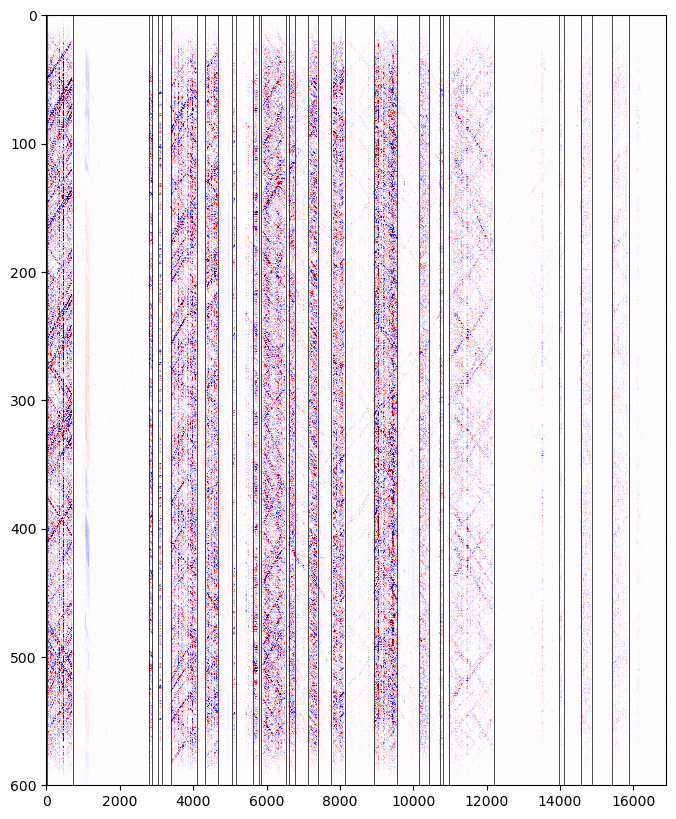

In [14]:
dt = 1./500
Mdt = dt*np.prod(M)

dx = 4

plt.figure(figsize=[8,10])

data_plot = data1[:, :]/5
clim = data_plot.std() *2

plot_ext = [0, data_plot.shape[0]*dx, data_plot.shape[1]*Mdt, 0]
plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim, extent = plot_ext)

for i in fiber_cum_len:
    plt.axvline(i, color='k', linewidth=0.5)
    
plt.xlim([plot_ext[0], plot_ext[1]])


(176, 6000) (149, 6000)


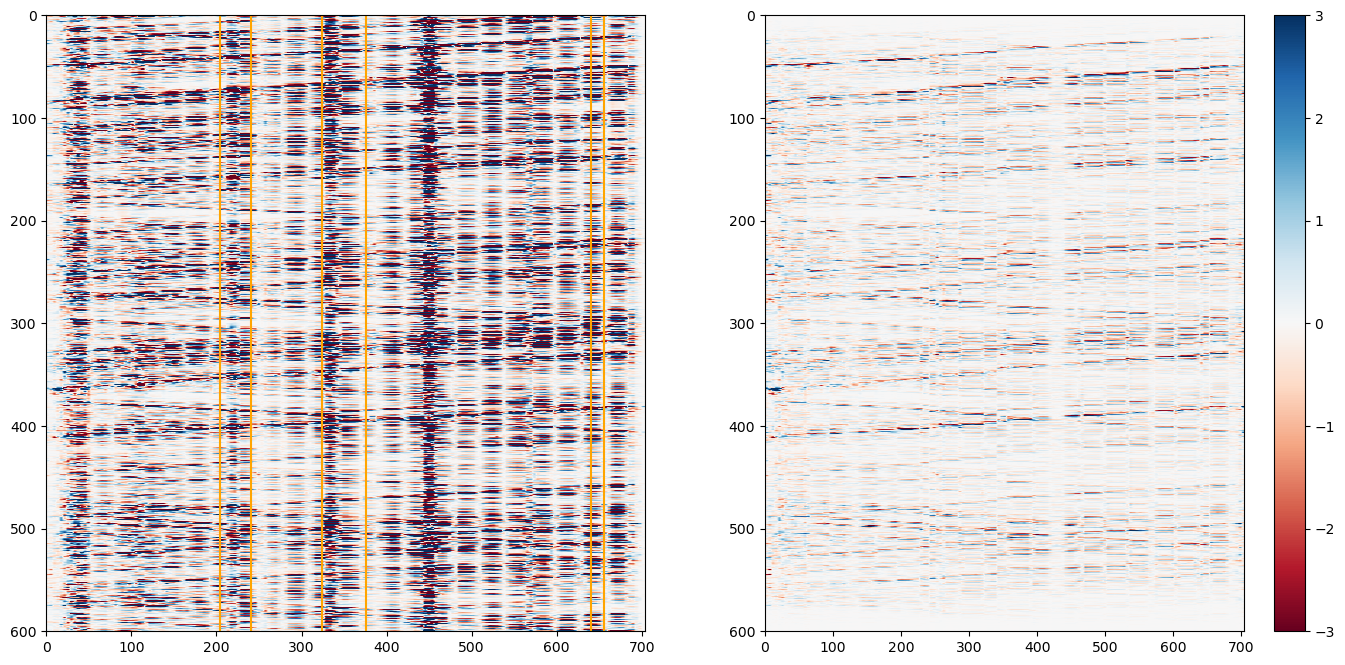

In [18]:
# dataEW = np.concatenate([data[:int(fiber_cum_len[1]/dx), :] for  ], axis=0)
# dataEW = data[int(fiber_cum_len[29]/dx):int(fiber_cum_len[30]/dx), :]
dataEW = data[int(fiber_cum_len[0]/dx):int(fiber_cum_len[1]/dx), :]
dataEW_d = np.delete(dataEW, np.r_[np.arange(51,60), np.arange(81,94), np.arange(160,165)], axis=0)
dataEW_d2 = np.delete(dataEW, np.r_[np.arange(51,60), np.arange(81,94)], axis=0)

print(dataEW.shape , dataEW_d.shape)
data2 = dp.tapering(dataEW_d, 0.2)
data2 = dp.lowpass(data2, Mdt,  fh=1)
data2 = dp.das_preprocess(data2)
data2 = data2 / (data2).std(axis=1, keepdims=True)

# dataSN = np.concatenate([data[:int(fiber_cum_len[1]/dx), :], data[int(fiber_cum_len[5]/dx):int(fiber_cum_len[6]/dx), :]], axis=0)

dataEW.shape
plt.figure(figsize=[17,8])

data_plot = dataEW
clim = data_plot.std() /3

plot_ext = [0, data_plot.shape[0]*dx, data_plot.shape[1]*Mdt, 0]
plt.subplot(121)
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim, extent = plot_ext)
plt.axvline(51*4,color='orange')
plt.axvline(60*4,color='orange')
plt.axvline(81*4,color='orange')
plt.axvline(94*4,color='orange')
plt.axvline(160*4,color='orange')
plt.axvline(164*4,color='orange')
plt.subplot(122)
data_plot = data2
clim = data_plot.std() *3
# plt.axvline((51)*4,color='orange')
# plt.axvline((160 )*4,color='orange')
# plt.axvline((51)*4,color='orange')
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim, extent = plot_ext)
plt.colorbar()

In [15]:
# dataEW = np.concatenate([data[:int(fiber_cum_len[1]/dx), :] for  ], axis=0)
# dataEW = data[int(fiber_cum_len[29]/dx):int(fiber_cum_len[30]/dx), :]
dataEW = data[int(fiber_cum_len[20]/dx):int(fiber_cum_len[21]/dx), :]
dataEW_d = np.delete(dataEW, np.r_[np.arange(51,60), np.arange(81,94), np.arange(160,165)], axis=0)
dataEW_d2 = np.delete(dataEW, np.r_[np.arange(51,60), np.arange(81,94)], axis=0)

print(dataEW.shape , dataEW_d.shape)
data2 = dp.tapering(dataEW_d, 0.2)
data2 = dp.lowpass(data2, Mdt,  fh=1)
data2 = dp.das_preprocess(data2)
data2 = data2 / (data2).std(axis=1, keepdims=True)

# dataSN = np.concatenate([data[:int(fiber_cum_len[1]/dx), :], data[int(fiber_cum_len[5]/dx):int(fiber_cum_len[6]/dx), :]], axis=0)

dataEW.shape
plt.figure(figsize=[17,8])

data_plot = dataEW
clim = data_plot.std() 

plot_ext = [0, data_plot.shape[0]*dx, data_plot.shape[1]*Mdt, 0]
plt.subplot(121)
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim, extent = plot_ext)
plt.axvline(51*4,color='orange')
plt.axvline(60*4,color='orange')
plt.axvline(81*4,color='orange')
plt.axvline(94*4,color='orange')
plt.axvline(160*4,color='orange')
plt.axvline(164*4,color='orange')
plt.subplot(122)
data_plot = data2
clim = data_plot.std() *3
# plt.axvline((51)*4,color='orange')
# plt.axvline((160 )*4,color='orange')
# plt.axvline((51)*4,color='orange')
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim, extent = plot_ext)
plt.colorbar()

IndexError: index 160 is out of bounds for axis 0 with size 100

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import glob, os
import datetime
import h5py
from scipy.signal import decimate

M = np.array([10, 5])
npylist = glob.glob('../../Highway_2024_0510/output/0628_data2/deci_7_7/*.npy')
print(len(npylist))
npylist.sort()

path = '../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5/'
if not os.path.exists(path):
    os.makedirs(path)

num = 1
# for k in range(0,len(npylist)//num - 1):
for k in range(0, 10):

    data = np.concatenate([np.load(npylist[i]) for i in range(k*num,(k+1)*num)], axis=-1)
    data = dp.das_preprocess(data)
    dataEW = data[int(fiber_cum_len[21]/dx):int(fiber_cum_len[22]/dx), :]
    dataEW_d = np.delete(dataEW, np.r_[np.arange(51,60), np.arange(81,94), np.arange(160,196)], axis=0)
    # dataEW_d = np.delete(dataEW, np.r_[np.arange(51,60), np.arange(81,94), np.arange(160,165)], axis=0)

    data2 = dp.tapering(dataEW_d, 0.2)
    data2 = dp.lowpass(data2, Mdt,  fh=2)
    data2 = dp.das_preprocess(data2)
    data2 = decimate(data2, 2).astype('float')
    data2 = data2 / (data2).std(axis=1, keepdims=True)
    plt.figure(figsize=[5.12,6.4])
    # plt.figure(figsize=[6.4,6.4]) 
    # plt.figure(figsize=[16,16]) 

    data_plot = data2[:, :]
    clim = data_plot.std() * 7
    plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim)
    plt.savefig(path+str(k)+'.png' )
    plt.close()

print(data2.shape)
# 5Hz 约700m 30s*3

662
(138, 150)


In [27]:
import eval_yolo_results2
import glob, os

# --------------可视化验证流程, 4个步骤依次运行-------------------
img_path = r'../../Highway_2024_0510/output/0628_data2/deci_7_7/pic/0.png' 
patch_dir =    r'../../Highway_2024_0510/output/0628_data2/deci_7_7/patches5'
yolo_predict = r'../../Highway_2024_0510/output/0628_data2/deci_7_7/yolo/labels'   # 每次预测完会存入新的文件夹，需修改“exp”对应的数字

img_flist = glob.glob('../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5/*.png')
# 1.img to patch, 待验证图像划分patches保存
if not os.path.exists(patch_dir):
    os.makedirs(patch_dir)
for img_path in img_flist:
    pathc_num, img_w,img_h= eval_yolo_results2.img2patch_pad(img_path, patch_dir, patch_size=64, padding=16)



In [28]:
# 2. yolo predict, 用训练好的yolo模型预测上一步骤中的patches
# 命令：python detect.py --weights ./runs/train/exp7/weights/best.pt --source ../datasets/traffic/images/val --imgsz 192 --iou-thres 0.5 --conf-thres 0.5 --save-txt
# 命令：python ../../yolo5/detect.py --weights ./runs/train/exp7/weights/best.pt --source ../../Highway_2024_0510/output/0628_data2/deci_7_7/patches --project '../../Highway_2024_0510/output/0628_data2/' --name 'deci_7_7/yolo/' --imgsz 192 --iou-thres 0.5 --conf-thres 0.5 --save-txt
! python ../../yolov5/detect.py --weights ../../yolov5/runs/train/exp7/weights/best.pt --source ../../Highway_2024_0510/output/0628_data2/deci_7_7/patches5 --project '../../Highway_2024_0510/output/0628_data2/' --name 'deci_7_7/yolo/' --imgsz 192 --iou-thres 0.5 --conf-thres 0.5 --save-txt

detect: weights=['../../yolov5/runs/train/exp7/weights/best.pt'], source=../../Highway_2024_0510/output/0628_data2/deci_7_7/patches5, data=../../yolov5/data/coco128.yaml, imgsz=[192, 192], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../Highway_2024_0510/output/0628_data2/, name=deci_7_7/yolo/, exist_ok=False, line_thickness=2, hide_labels=True, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-7-16 Python-3.11.5 torch-2.3.1+cu121 CPU

Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/6250 /home/wuzm/data/项目交接-基于深度学习的车道线检测/Highway_2024_0510/output/0628_data2/deci_7_7/patches5/0_00000.png: 192x192 (no detections), 34.1ms
image 2/6250 /home/wuzm/data/项目交接-基于深度学习的车道线检测/Highway_2024_0510/output/0628_data2/deci_7_7/patches5/0

In [29]:
yolo_predict = r'../../Highway_2024_0510/output/0628_data2/deci_7_7/yolo9/labels'   # 每次预测完会存入新的文件夹，需修改“exp”对应的数字
img_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/predict_vis_result17"
# # 3. draw predicted lines to patch, 将预测结果绘制到每一patch上
# import eval_yolo_results2
# img_flist = glob.glob('../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5_label/*.png')

# patch_dir = r'../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5_label/patch'
# yolo_predict = r'../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5_label/yolo'
eval_yolo_results2.txt2line(yolo_predict,patch_dir)

# 4. patch to img, 将绘制了预测结果的patch合并为大图像并保存
if not os.path.exists(img_save_dir):
    os.makedirs(img_save_dir)
img_flist.sort()
print(len(img_flist))
for img_path in img_flist:
    img_name = img_path.split("/")[-1].replace(".png","")
    img_save_path = os.path.join(img_save_dir,img_name+'.png')
    eval_yolo_results2.patch2img_pad(patch_dir,img_name, img_save_path,img_w,img_h, padding=16 , patch_num=pathc_num)



10


In [12]:
import traffic_data_preprocess as tdp
import glob, os
#train
#-----------------------步骤一：获取patch和对应的yolo label----------------------------
data_dir =r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5_label"
patch_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5_label/patch"
yolo_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic5_label/yolo"

if not os.path.exists(yolo_save_dir):
    os.makedirs(yolo_save_dir)
    os.makedirs(patch_save_dir)
tdp.get_patches(data_dir,patch_save_dir,yolo_save_dir)

#---------------步骤二：划分训练集和测试集----------------------------------
label_src_dir = yolo_save_dir
img_src_dir = patch_save_dir

train_label_save_dir = r"../../data/yolo_dataset/labels/train"
val_label_save_dir = r"../../data/yolo_dataset/labels/val"
train_img_save_dir = r"../../data/yolo_dataset/images/train"
val_img_save_dir = r"../../data/yolo_dataset/images/val"
# train_label_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic3_label/labels/train"
# val_label_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic3_label/labels/val"
# train_img_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic3_label/images/train"
# val_img_save_dir = r"../../Highway_2024_0510/output/0628_data2/deci_7_7/pic3_label/images/val"
if not os.path.exists(train_label_save_dir):
    os.makedirs(train_label_save_dir)
    os.makedirs(val_label_save_dir)
    os.makedirs(train_img_save_dir)
    os.makedirs(val_img_save_dir)

ratio = 0.9
with_neg = False
tdp.devide_dataset(label_src_dir,
                img_src_dir,
                train_label_save_dir,
                train_img_save_dir,
                val_label_save_dir,
                val_img_save_dir,
                ratio,
                with_neg)


['0.png', '1.png', '2.png', '3.png']
0
num of lines:86
1
num of lines:85
2
num of lines:63
3
num of lines:76


In [5]:
! python ../../yolov5/train.py --data traffic_data_hw.yaml --weights '' --cfg traffic_yolov5s.yaml --img 192 --batch-size 64 --weights ../../yolov5/runs/train/exp10/weights/best.pt

train: weights=../../yolov5/runs/train/exp10/weights/best.pt, cfg=traffic_yolov5s.yaml, data=traffic_data_hw.yaml, hyp=../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=192, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=../../yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2024-7-16 Python-3.11.5 torch-2.3.1+cu121 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_de


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      98/99         0G    0.03283    0.01123    0.00713        109        192: 100%|██████████| 23/23 [01:00<00:00,  2.61s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
                   all        146        459      0.152      0.111     0.0779     0.0307

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      99/99         0G    0.03181    0.01108   0.006847        119        192: 100%|██████████| 23/23 [01:07<00:00,  2.95s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]
                   all        146        459      0.142        0.1     0.0729     0.0296

100 epochs completed in 1.839 hours.
Optimizer stripped from runs/train/exp13/weights/last.pt, 14.3MB
Optimizer stripped from runs/train/exp13/weights/best.pt, 14.3MB

Validating runs/train/exp13/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
                   all        146        459      0.328      0.356      0.299       0.13
                line_l        146        231      0.306      0.489      0.363      0.151
                line_r        146        228      0.349      0.224      0.236      0.109
Results saved to runs/train/exp13


100 epochs completed in 0.994 hours.
Optimizer stripped from runs/train/exp19/weights/last.pt, 14.3MB
Optimizer stripped from runs/train/exp19/weights/best.pt, 14.3MB

Validating runs/train/exp19/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]
                   all        136        351      0.395      0.375      0.319      0.137
                line_l        136        182      0.434      0.407      0.365       0.15
                line_r        136        169      0.355      0.342      0.274      0.124
Results saved to runs/train/exp19

100 epochs completed in 0.632 hours.
Optimizer stripped from runs/train/exp8/weights/last.pt, 14.3MB
Optimizer stripped from runs/train/exp8/weights/best.pt, 14.3MB

Validating runs/train/exp8/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]
                   all        136        351      0.379      0.359      0.322      0.135
                line_l        136        182      0.413      0.352       0.36      0.149
                line_r        136        169      0.345      0.367      0.283      0.122
Results saved to runs/train/exp8

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      99/99         0G    0.02705   0.007278   0.002177        102        192: 100%|██████████| 135/135 [02:12<00:00,  1.02it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 8/8 [00:09<00:00,  1.13s/it]
                   all        955       1811      0.628      0.499      0.517      0.255

100 epochs completed in 4.268 hours.
Optimizer stripped from runs/train/exp10/weights/last.pt, 14.3MB
Optimizer stripped from runs/train/exp10/weights/best.pt, 14.3MB

Validating runs/train/exp10/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 8/8 [00:08<00:00,  1.11s/it]
                   all        955       1811      0.665      0.492      0.555      0.284
                line_l        955       1220      0.653      0.505      0.542      0.267
                line_r        955        591      0.678      0.479      0.568      0.301
Results saved to runs/train/exp10

Validating ../../yolov5/runs/train/exp14/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 9/9 [00:16<00:00,  1.82s/it]
                   all       1127       2284       0.76      0.592      0.623      0.382
                line_l       1127       1436      0.732       0.54      0.565      0.328
                line_r       1127        848      0.788      0.643      0.682      0.437
Results saved to ../../yolov5/runs/train/exp14

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      99/99         0G    0.02978    0.01066   0.005571         89        192: 100%|██████████| 221/221 [02:20<00:00,  1.57it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]
                   all       2289       9740      0.873       0.64      0.753      0.557

100 epochs completed in 4.442 hours.
Optimizer stripped from ../../yolov5/runs/train/exp15/weights/last.pt, 14.3MB
Optimizer stripped from ../../yolov5/runs/train/exp15/weights/best.pt, 14.3MB

Validating ../../yolov5/runs/train/exp15/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]
                   all       2289       9740      0.873       0.64      0.753      0.557
                line_l       2289       4821       0.86      0.621      0.728      0.527
                line_r       2289       4919      0.885       0.66      0.779      0.587
Results saved to ../../yolov5/runs/train/exp15


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      99/99         0G    0.02341   0.007916   0.003102         25        192: 100%|██████████| 192/192 [02:02<00:00,  1.57it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]
                   all       1845       7337      0.914      0.774      0.824      0.658

100 epochs completed in 3.877 hours.
Optimizer stripped from ../../yolov5/runs/train/exp17/weights/last.pt, 14.3MB
Optimizer stripped from ../../yolov5/runs/train/exp17/weights/best.pt, 14.3MB

Validating ../../yolov5/runs/train/exp17/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]
                   all       1845       7337      0.914      0.773      0.823      0.658
                line_l       1845       3659      0.893      0.739      0.788      0.615
                line_r       1845       3678      0.934      0.808      0.859      0.701
Results saved to ../../yolov5/runs/train/exp17

                   all       2638       9451      0.919      0.782      0.837      0.672

100 epochs completed in 4.644 hours.
Optimizer stripped from ../../yolov5/runs/train/exp11/weights/last.pt, 14.3MB
Optimizer stripped from ../../yolov5/runs/train/exp11/weights/best.pt, 14.3MB

Validating ../../yolov5/runs/train/exp11/weights/best.pt...
Fusing layers... 
traffic_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]
                   all       2638       9451      0.919      0.782      0.837      0.672
                line_l       2638       4688      0.906      0.755      0.811       0.64
                line_r       2638       4763      0.932       0.81      0.863      0.704
Results saved to ../../yolov5/runs/train/exp11